# Project BattChem
## Current Status, Explaination, and Workflow
Updated 2020-05-15
------------------------------------------------------
Currently working on user interactions *(via notebook widgets and functions!?!)*, and will also work towards having more fundamental calculations availiable for EChem-based modeling *(current models are highly empirical)*

In [1]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ipywidgets as widgets

import nernst_reference  # For now includes self-test: Generates an LCO/G Curve. 
# import nernst_widgets  # For now, Empty. Will use to store best widgets tested here!

In [2]:
# Testing Basic Widgets?
widgets.Dropdown()
widgets.FloatSlider(100)

FloatSlider(value=100.0)

In [3]:
m = widgets.FloatSlider(100)

In [4]:
display(m)
print(m.value)

FloatSlider(value=100.0)

100.0


In [15]:
#Let's explore what comes in Nernst_Reference for now
print(nernst_reference.E.keys())

# In reality though, those are not actually properly filled out... 
# Only LFP, LMO, and LCO have data in them
cells_given = list(nernst_reference.E.keys())
half_cells=[]
for chemistry in cells_given:
    if nernst_reference.E[chemistry]: #If not an empty entry
        half_cells.append(chemistry)
        
Ano_chem = widgets.Dropdown(options=half_cells, value=half_cells[-1],
                        description="Anode Half-Cell:", disabled=False)

Cat_chem = widgets.Dropdown(options=half_cells, value=half_cells[0],
                        description="Cathode Half-Cell:", disabled=False)

display(Cat_chem,Ano_chem)

dict_keys(['LFP', 'LMO', 'LCO', 'LNO', 'NCA', 'NMC111', 'GRA_Br', 'GRA_Li', 'NTP', 'TPO'])


Dropdown(description='Cathode Half-Cell:', options=('LFP', 'LMO', 'LCO', 'GRA_Li'), value='LFP')

Dropdown(description='Anode Half-Cell:', index=3, options=('LFP', 'LMO', 'LCO', 'GRA_Li'), value='GRA_Li')

In [16]:
# I've made a starting dictionary of Reference Electrode E_0 values as well
print(nernst_reference.Refs.keys())
# However, I should actually include a dictionary of Half-Cell STANDARDS,
#    and then a separate Refs dictionary of common Non-Standards to use...
refs_list=list(nernst_reference.Refs.keys())
Ref_chem = widgets.Dropdown(options=refs_list, value=refs_list[0],
                        description="Reference Electrode:", disabled=False)

display(Ref_chem)

dict_keys(['Li', 'SCE', 'NCE', 'AgCl', 'MSE', 'SHE', 'NHE', 'AgSO'])


Dropdown(description='Reference Electrode:', options=('Li', 'SCE', 'NCE', 'AgCl', 'MSE', 'SHE', 'NHE', 'AgSO')…

In [17]:
print("Cathode:\t{}\nAnode:\t\t{}\nReference:\t{}".format(Cat_chem.value,
                                                          Ano_chem.value, 
                                                          Ref_chem.value))

Cathode:	LFP
Anode:		GRA_Li
Reference:	SHE


#### Creating Half-Cell Curves

Cathode Curve Construction: LFP (V vs Li+/SHE)


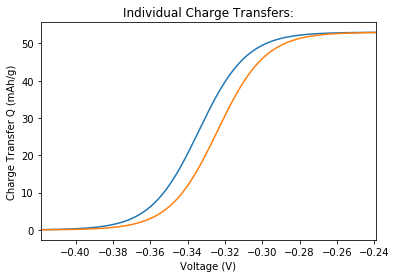

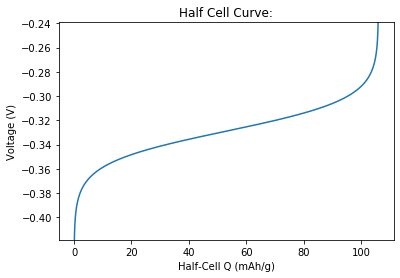

In [19]:
Ano, Cat = nernst_reference.Choose_Electrodes(Ano = Ano_chem.value,
                                              Cat = Cat_chem.value, 
                                              Ref = Ref_chem.value)
Cathode_mAhg = nernst_reference.Show_Curves(Cat, 1, plotting=1)
print("Cathode Curve Construction: "+
      "{} (V vs Li+/{})".format(Cat_chem.value, Ref_chem.value))

Anode Half-Cell Curve Construction: LFP (V vs Li+/SHE)


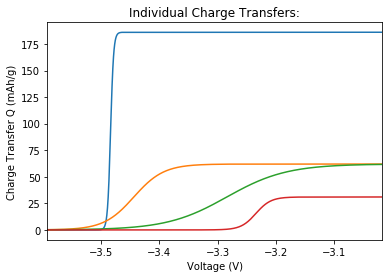

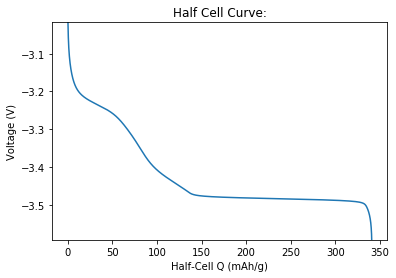

In [21]:
Anode_mAhg = nernst_reference.Show_Curves(Ano, -1, plotting=1) 
print("Anode Half-Cell Curve Construction: "+
      "{} (V vs Li+/{})".format(Cat_chem.value, Ref_chem.value))

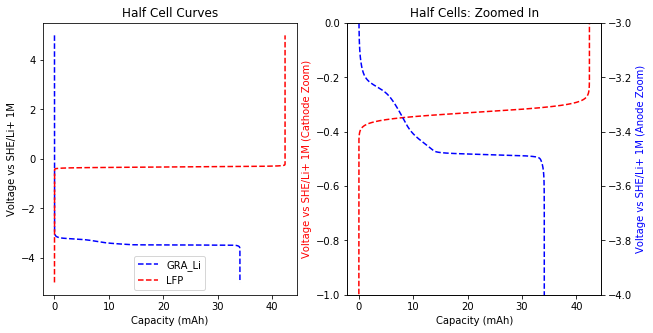

In [37]:
fig,ax = plt.subplots(1,2,figsize=[10,5])
anode_m = 100/1000 #kg (times mAh/g will = Ah Loading)
cathode_m = 400/1000 #kg (times mAh/g = Ah Cathode Loading)
Ano_QV = [Anode_mAhg[0]*anode_m, Anode_mAhg[1]]
Cat_QV = [Cathode_mAhg[0]*cathode_m, Cathode_mAhg[1]] 

# First Plot: Both Electrodes on same Y
ax[0].plot(Ano_QV[0],Ano_QV[1],'b--',label='{}'.format(Ano_chem.value))
ax[0].plot(Cat_QV[0],Cat_QV[1],'r--',label='{}'.format(Cat_chem.value))
ax[0].set_xlabel('Capacity (mAh)')
ax[0].set_ylabel('Voltage vs {}/Li+ 1M'.format(Ref_chem.value))
ax[0].set_title('Half Cell Curves')

# Second Plot: Separate Y Axis, to zoom in. 
ax1 = ax[1].twinx()
ax1.plot(Ano_QV[0],Ano_QV[1],'b--',label='{}'.format(Ano_chem.value))
ax[1].plot(Cat_QV[0],Cat_QV[1],'r--',label='{}'.format(Cat_chem.value))
ax[1].set_xlabel('Capacity (mAh)')
ax[1].set_ylabel('Voltage vs {}/Li+ 1M (Cathode Zoom)'.format(Ref_chem.value),c='r')
ax1.set_ylabel('Voltage vs {}/Li+ 1M (Anode Zoom)'.format(Ref_chem.value),c='b')
ax[1].set_title('Half Cells: Zoomed In')

# Cathode Zoom:     (Manually Adjust for now?)
ax[1].set_ylim([-1,0])
# Anode Zoom:       (Manually Adjust for now?)
ax1.set_ylim([-4,-3])

ax[0].legend(loc='lower center')

In [33]:
a= min(Ano_QV[1])
print([Ano_QV[1][a],Ano_QV[1][-a]])

[-4.000150002500041, 3.999983333055551]


682.0


Text(0.5, 0, 'Capacity (mAh)')

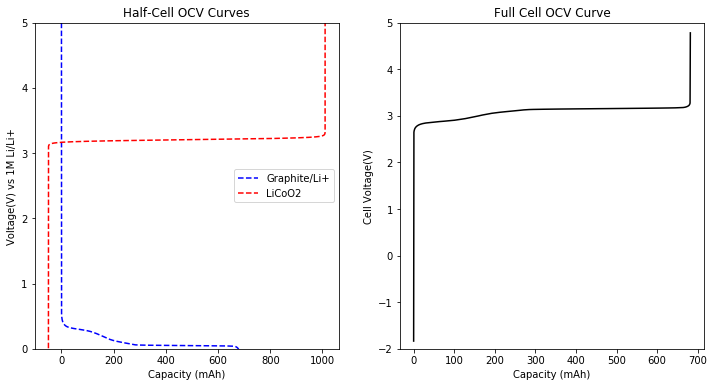

In [11]:
# Modify SOC Q-Balance and Anode, Cathode mass to create the full cell
# Note: You may enter kilograms, but then the SOC imbalance is in A*hrs

anode_m = 2 #grams
cathode_m = 10 #grams
SOC_mAh = 50 #mAh imbalance
Ano_QV, Cat_QV, Cell_QV = nernst_reference.combine_curves(Anode_mAhg,
                                                          anode_m,
                                                          Cathode_mAhg, 
                                                          cathode_m, 
                                                          SOC_mAh)

fig, ax = plt.subplots(1,2,figsize=[12,6])
ax[0].plot(Ano_QV[0],Ano_QV[1],'b--',label='Graphite/Li+')
ax[0].plot(Cat_QV[0],Cat_QV[1],'r--',label='LiCoO2')
ax[1].plot(Cell_QV[0],Cell_QV[1],'k-')

ax[0].set_ylim([0,5])
ax[1].set_ylim([-2,5])
ax[0].legend(loc='right')


ax[0].set_title('Half-Cell OCV Curves')
ax[1].set_title('Full Cell OCV Curve')
ax[0].set_ylabel('Voltage(V) vs 1M Li/Li+')
ax[1].set_ylabel('Cell Voltage(V)')
ax[0].set_xlabel('Capacity (mAh)')
ax[1].set_xlabel('Capacity (mAh)')